# Load and compare the experiment results

In [2]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
from src.utils import *
from src.mi_estimators import *

In [3]:
d = 20
hidden_layer = 2
hidden_dim = 100
reg = 0
alpha = 1e-6 #0.02
ma_rate = 0.01

In [4]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

data = GaussianData(400, d=d, rho=0.9)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

In [5]:
infonce_chkpt_name = f'./results/InfoNCE_dim{d}_reg{reg}.pt'
infonce_exc_chkpt_name = f'./results/InfoNCE_exc_dim{d}_reg{reg}.pt'
smoothed_infonce_chkpt_name = f'./results/Smoothed_InfoNCE_dim{d}_reg{1}_alpha{alpha}.pt'
chkpt_list = [infonce_chkpt_name, infonce_exc_chkpt_name, smoothed_infonce_chkpt_name]
mi_estimates = []

In [6]:
for cpt in chkpt_list:
    checkpoint = torch.load(
        cpt, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    mi_copy = mi_list.copy()
    for k in range(1,len(mi_list)):
        mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]
    mi_estimates.append(mi_copy)
print('Previous results loaded.')

Previous results loaded.


In [7]:
import src.entropy_estimators as ee

KSG = ee.mi(X.cpu().numpy(),Y.cpu().numpy())

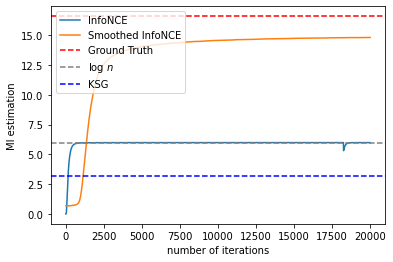

In [8]:
plt.plot(mi_estimates[0], label='InfoNCE')
# plt.plot(mi_estimates[1], label='InfoNCE exc')
plt.plot(mi_estimates[2], label='Smoothed InfoNCE')
plt.axhline(Ground_truth,label='Ground Truth',linestyle='--',color='red')
plt.axhline(np.log(400),label='log $n$',linestyle='--',color='grey')
plt.axhline(KSG,label='KSG',linestyle='--',color='blue')

plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()
# plt.savefig(f'./results/InfoNCE_dim{opt.d}.pdf')

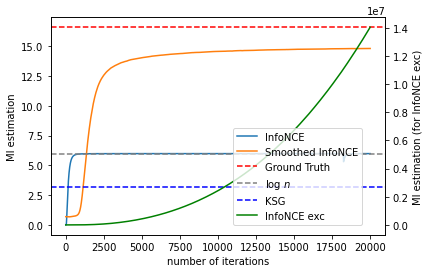

In [9]:
fig = plt.figure()

ax1 = fig.add_subplot()
ax1.plot(mi_estimates[0], label='InfoNCE')
# plt.plot(mi_estimates[1], label='InfoNCE exc')
ax1.plot(mi_estimates[2], label='Smoothed InfoNCE')
ax1.axhline(Ground_truth,label='Ground Truth',linestyle='--',color='red')
ax1.axhline(np.log(400),label='log $n$',linestyle='--',color='grey')
ax1.axhline(KSG,label='KSG',linestyle='--',color='blue')

ax1.set_xlabel('number of iterations')
ax1.set_ylabel('MI estimation')

ax2 = ax1.twinx()  # this is the important function
ax2.plot(mi_estimates[1], label='InfoNCE exc', color='green')
ax2.set_ylabel('MI estimation (for InfoNCE exc)')

# ax1.legend()
# ax2.legend()
fig.legend(loc='lower right', bbox_to_anchor=(0.85,0.15))
plt.show()

In [10]:
Ground_truth

16.607312068216512

In [11]:
KSG

3.2253809124293786